# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, shutil
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs
from envs.env_rl_restrict import PairTradingEnv
from params import *

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
import pickle

with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1331282


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do an experimental run with randomly generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0.002, verbose=1, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('position': Discrete(3), 'threshold': Discrete(5), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(4)
action_space.sample: 0
networth: 0.9996000000000002, action: 2, position: 2, kc: 1 order_amount0: 20.634, order_amount1: -18.493000000000002 holding0: 20.634, holding1: -18.493000000000002 cash: 0.9996, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 0.9992000000000001, action: 1, position: 1, kc: 1 order_amount0: -20.634, order_amount1: 18.493000000000002 holding0: 0, holding1: 0 cash: 0.9992000000000001, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 0.9992000000000001, action: 3, position: 1, kc: 1 order_amount0: -20.634, order_amount1: 18.493000000000002 holding0: 0, holding1: 0 cash: 0.9992000000000001, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 0.9992000000000001, action: 3, position: 1, kc: 1 order_amount0: -20.634, order_amount1: 18.49300

## Models from stable_baselines3

Delete existing tensorboard logs

In [18]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Train with training data

In [6]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=500000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [7]:
'''A2C'''

from stable_baselines3 import A2C

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=500000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [19]:
'''DQN'''

from stable_baselines3 import DQN

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=100000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [9]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading")

In [10]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [11]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

bankrupted!


### Analyze with Quanstats

In [13]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 23:59:59.999000', '0.9859001309751649']
The ending capital of networth_dqn.csv is ['2023-02-23 13:37:59.999000', '-3.597023403351107e-05']
The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '0.925706077365401']
The best model is networth_a2c.csv


In [14]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: -2%
Total orders count: 479569
Total long action: 190695
Total short action: 189070
Won orders count: 190695
Lost orders count: 189070
Win/Loss order ratio: 1.0085947003755222
Avg order pnl: -2.786939575258962e-08
Avg order pnl won: 3.862285091677316e-05
Avg order pnl lost: -3.90254924304529e-05
Avg long order pnl: -0.00081166599423102
Avg short order pnl: -1.2490788343428098e-08


In [15]:
total_return = best_return['values'][-1]/best_return['values'][0]
total_year = (best_return.index[-1]-best_return.index[0]).days/365.25
cagr = total_return**(1/total_year)-1
print(cagr)

-0.015454792541000018


                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-11-30
Risk-Free Rate      0.0%
Time in Market      80.0%

Cumulative Return   -1.41%
CAGR﹪              -1.07%

Sharpe              -0.01
Prob. Sharpe Ratio  37.19%
Sortino             -0.01
Sortino/√2          -0.01
Omega               1.0

Max Drawdown        -1.99%
Longest DD Days     132

Gain/Pain Ratio     -0.2
Gain/Pain (1M)      -0.74

Payoff Ratio        0.99
Profit Factor       1.0
Common Sense Ratio  1.0
CPC Index           0.5
Tail Ratio          1.0
Outlier Win Ratio   6.14
Outlier Loss Ratio  4.04

MTD                 -0.11%
3M                  0.04%
6M                  -0.97%
YTD                 -1.41%
1Y                  -1.41%
3Y (ann.)           -1.07%
5Y (ann.)           -1.07%
10Y (ann.)          -1.07%
All-time (ann.)     -1.07%

Avg. Drawdown       -0.29%
Avg. Drawdown Days  20
Recovery Factor     0.67
Ulcer Index         0.01
Serenity Index      -0.

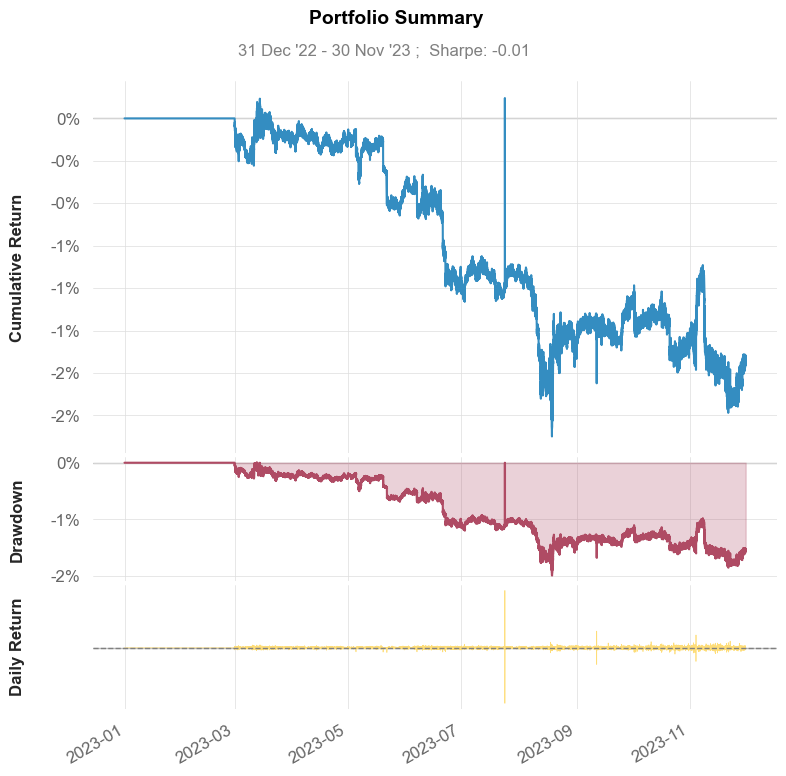

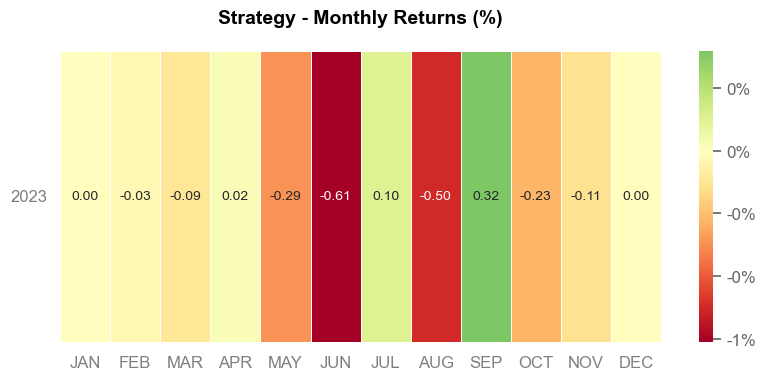

In [16]:
qs.reports.basic(best_return['returns'])